<a href="https://colab.research.google.com/github/cindyy-chen/iss_movement/blob/main/manipulating_ISS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the ISS Movement

## Required packages
- Matplotlib
- NumPy
- Pandas
- Cartopy (might not be needed at the end)
- Shapely
- GeoPandas
- MovingPandas
- HoloViews
- hvplot

In [9]:
!pip install global_land_mask
!pip install meteostat
!pip install movingpandas
!pip install hvplot
!pip install geopy
!pip install countryinfo
!pip install holoviews
!pip install reverse_geocode
!pip install cartopy
!pip install geoview
!pip install shapely
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.2/602.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocode: filename=reverse_geocode-1.4.1-py3-none-any.whl size=1637825 sha256=656f6353bed94c102bb3952933ed28858eab4eb3948d30331d67982a7347ddd7
  Stored in directory: /root/.cache/pip/wheels/8d/2f/ac/dd0a91b3e7e0aa6e5f77bfbc7f7834aecce4a01cba231ba024
Successfully built reverse_geocode
ERROR: Could not find a version that satisfies the requirement catropy (from versions: none)
ERROR: No matching distribution found for catropy
  error: subprocess-exi

In [12]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 23.4 MB/s eta 0:00:00


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from pathlib import Path
import datetime as dt

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [14]:
import cartopy
import cartopy.crs as ccrs

In [15]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

In [17]:
import holoviews as hv
import hvplot.pandas

In [18]:
plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
hv.opts.defaults(hv.opts.Overlay(active_tools=['wheel_zoom'],
                                 frame_width=500, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

In [19]:
mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable : /usr/bin/python3
machine    : Linux-6.1.58+-x86_64-with-glibc2.35

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /usr/local/lib/python3.10/dist-packages/fiona/gdal_data
PROJ       : 9.3.0
PROJ data dir: /usr/local/lib/python3.10/dist-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 1.5.3
fiona      : 1.9.5
numpy      : 1.25.2
shapely    : 2.0.3
rtree      : 1.2.0
pyproj     : 3.6.1
matplotlib : 3.7.1
mapclassify: None
geopy      : 2.3.0
holoviews  : 1.17.1
hvplot     : 0.9.2
geoviews   : None
stonesoup  : None


## Step 1: Read the CSV File

In [20]:
file_name = "https://raw.githubusercontent.com/cindyy-chen/iss_movement/main/iss_timeseries_trajectories_20240303_104539.csv"


In [21]:
df = pd.read_csv(file_name)

In [22]:
df

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country
0,2024-03-03 10:45:39,-36.9477,-63.3776,True,22.4,5.7,0,Argentina
1,2024-03-03 10:45:45,-37.1914,-63.0247,True,21.7,3.1,0,Argentina
2,2024-03-03 10:45:52,-37.4542,-62.6395,True,21.1,3.7,0,Argentina
3,2024-03-03 10:45:58,-37.6752,-62.3114,True,19.9,10.2,0,Argentina
4,2024-03-03 10:46:03,-37.8953,-61.9813,True,20.8,11.7,0,Argentina
...,...,...,...,...,...,...,...,...
3996,2024-03-03 17:00:09,-43.6702,-145.9861,False,17.0,39.9,4,French Polynesia
3997,2024-03-03 17:00:14,-43.8520,-145.5860,False,16.8,40.4,4,French Polynesia
3998,2024-03-03 17:00:20,-44.0321,-145.1835,False,16.5,43.6,4,French Polynesia
3999,2024-03-03 17:00:26,-44.2268,-144.7414,False,16.2,44.1,4,French Polynesia


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   t            4001 non-null   object 
 1   latitude     4001 non-null   float64
 2   longitude    4001 non-null   float64
 3   land_flag    4001 non-null   bool   
 4   temperature  4001 non-null   float64
 5   windspeed    4001 non-null   float64
 6   traj_id      4001 non-null   int64  
 7   country      4001 non-null   object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 222.8+ KB


Note that the column `t` has string as data type. We want it to be a datetime object.

## Step 2: Perform Conversions

#### Convert the `t` column into a datetime object

In [24]:
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')

Make the `t` column as index

In [25]:
df.set_index('t', inplace=True)

In [26]:
df.head(4)

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country
t,,,,,,,
2024-03-03 10:45:39,-36.9477,-63.3776,True,22.4,5.7,0,Argentina
2024-03-03 10:45:45,-37.1914,-63.0247,True,21.7,3.1,0,Argentina
2024-03-03 10:45:52,-37.4542,-62.6395,True,21.1,3.7,0,Argentina
2024-03-03 10:45:58,-37.6752,-62.3114,True,19.9,10.2,0,Argentina


#### Count the number of locations that are on land:
- `land_flag` is `True` for land and `False` otherwise (ocean).

In [27]:
df.land_flag.sum()

1128

#### Convert the positions (latitude and longitude) into `Shapely` POINT objects:
- Add a `geometry` column

In [28]:
df['geometry'] = [shpgeom.Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
t,,,,,,,,
2024-03-03 10:45:39,-36.9477,-63.3776,True,22.4,5.7,0,Argentina,POINT (-63.3776 -36.9477)
2024-03-03 10:45:45,-37.1914,-63.0247,True,21.7,3.1,0,Argentina,POINT (-63.0247 -37.1914)
2024-03-03 10:45:52,-37.4542,-62.6395,True,21.1,3.7,0,Argentina,POINT (-62.6395 -37.4542)
2024-03-03 10:45:58,-37.6752,-62.3114,True,19.9,10.2,0,Argentina,POINT (-62.3114 -37.6752)
2024-03-03 10:46:03,-37.8953,-61.9813,True,20.8,11.7,0,Argentina,POINT (-61.9813 -37.8953)
...,...,...,...,...,...,...,...,...
2024-03-03 17:00:09,-43.6702,-145.9861,False,17.0,39.9,4,French Polynesia,POINT (-145.9861 -43.6702)
2024-03-03 17:00:14,-43.8520,-145.5860,False,16.8,40.4,4,French Polynesia,POINT (-145.586 -43.852)
2024-03-03 17:00:20,-44.0321,-145.1835,False,16.5,43.6,4,French Polynesia,POINT (-145.1835 -44.0321)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4001 entries, 2024-03-03 10:45:39 to 2024-03-03 17:00:31
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   latitude     4001 non-null   float64
 1   longitude    4001 non-null   float64
 2   land_flag    4001 non-null   bool   
 3   temperature  4001 non-null   float64
 4   windspeed    4001 non-null   float64
 5   traj_id      4001 non-null   int64  
 6   country      4001 non-null   object 
 7   geometry     4001 non-null   object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 254.0+ KB


In [30]:
df.head(4)

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
t,,,,,,,,
2024-03-03 10:45:39,-36.9477,-63.3776,True,22.4,5.7,0,Argentina,POINT (-63.3776 -36.9477)
2024-03-03 10:45:45,-37.1914,-63.0247,True,21.7,3.1,0,Argentina,POINT (-63.0247 -37.1914)
2024-03-03 10:45:52,-37.4542,-62.6395,True,21.1,3.7,0,Argentina,POINT (-62.6395 -37.4542)
2024-03-03 10:45:58,-37.6752,-62.3114,True,19.9,10.2,0,Argentina,POINT (-62.3114 -37.6752)


## Step 3: Manipulation with GeoPandas

#### Create a GeoDataFrame

In [31]:
iss_gdf = gpd.GeoDataFrame(df, geometry="geometry")
iss_gdf

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
t,,,,,,,,
2024-03-03 10:45:39,-36.9477,-63.3776,True,22.4,5.7,0,Argentina,POINT (-63.37760 -36.94770)
2024-03-03 10:45:45,-37.1914,-63.0247,True,21.7,3.1,0,Argentina,POINT (-63.02470 -37.19140)
2024-03-03 10:45:52,-37.4542,-62.6395,True,21.1,3.7,0,Argentina,POINT (-62.63950 -37.45420)
2024-03-03 10:45:58,-37.6752,-62.3114,True,19.9,10.2,0,Argentina,POINT (-62.31140 -37.67520)
2024-03-03 10:46:03,-37.8953,-61.9813,True,20.8,11.7,0,Argentina,POINT (-61.98130 -37.89530)
...,...,...,...,...,...,...,...,...
2024-03-03 17:00:09,-43.6702,-145.9861,False,17.0,39.9,4,French Polynesia,POINT (-145.98610 -43.67020)
2024-03-03 17:00:14,-43.8520,-145.5860,False,16.8,40.4,4,French Polynesia,POINT (-145.58600 -43.85200)
2024-03-03 17:00:20,-44.0321,-145.1835,False,16.5,43.6,4,French Polynesia,POINT (-145.18350 -44.03210)


#### Quick plot

<Axes: >

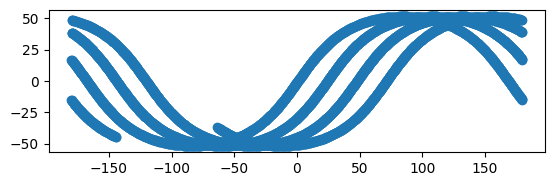

In [32]:
iss_gdf.plot()

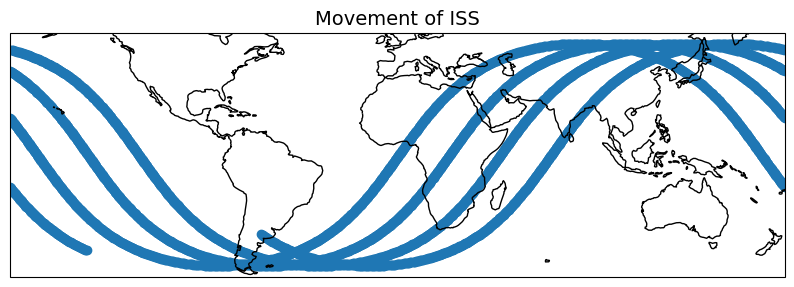

In [33]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf.plot(
    ax=ax
)

ax.coastlines()
plt.title('Movement of ISS', fontsize = 14);

#### Plot by country crossed using Cartopy

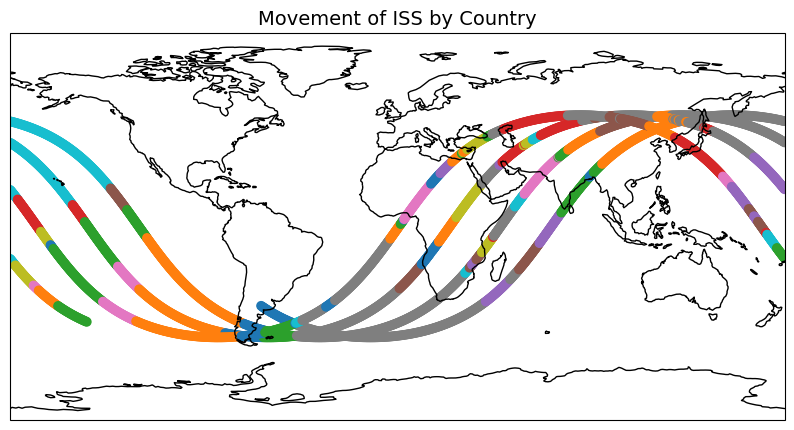

In [34]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf.plot("country", ax=ax)

ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

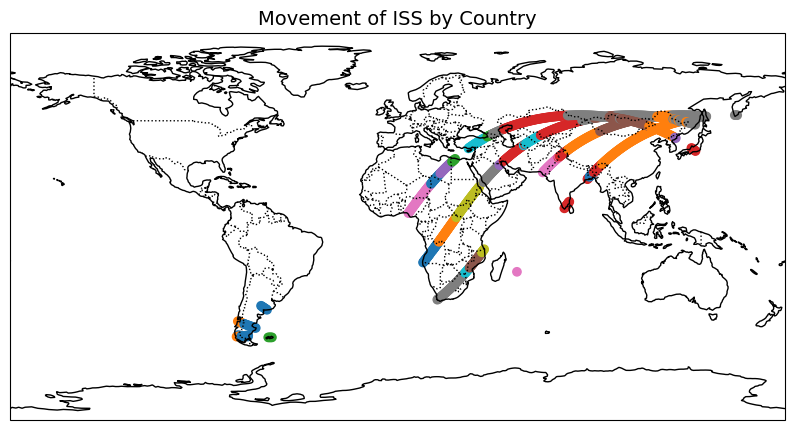

In [35]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf[iss_gdf.land_flag==True].plot("country", ax=ax)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

#### Plot by country crossed using the Natural Earth Database background image

In [36]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

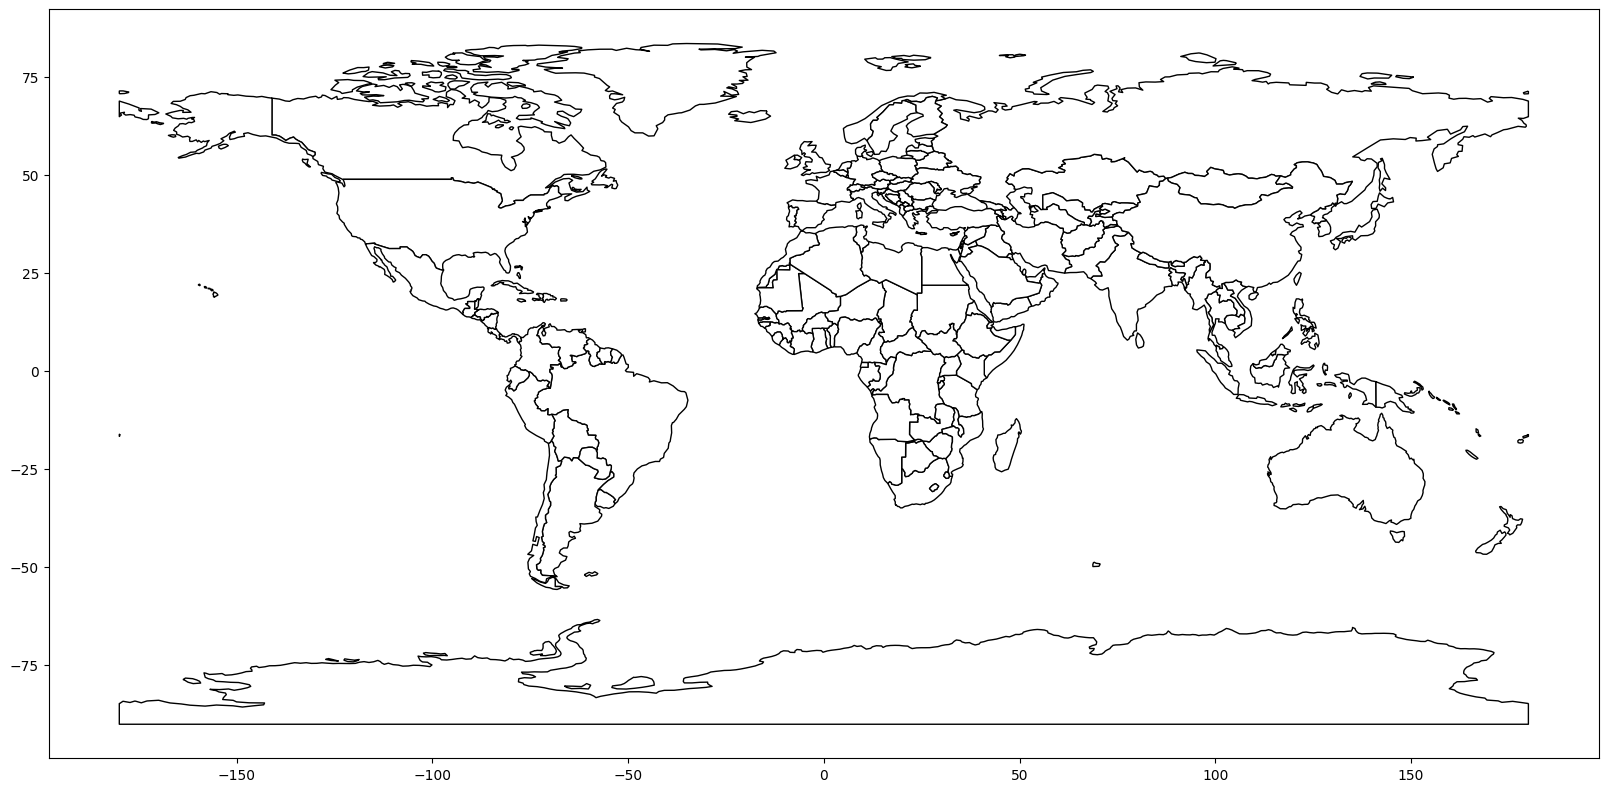

In [37]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)

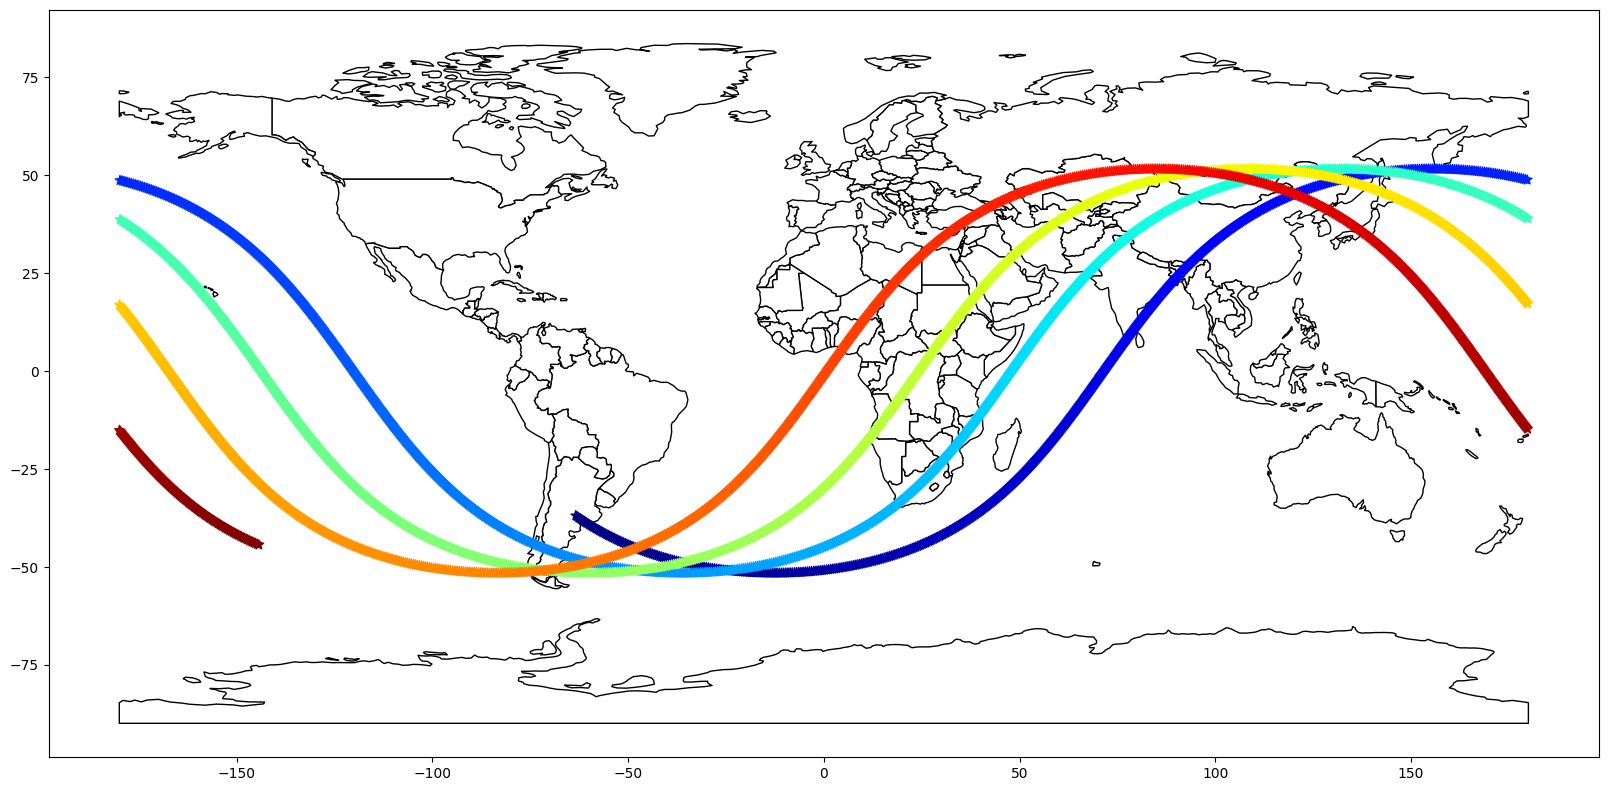

In [38]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_gdf.plot(ax=base, marker="*", markersize=50, cmap = 'jet');

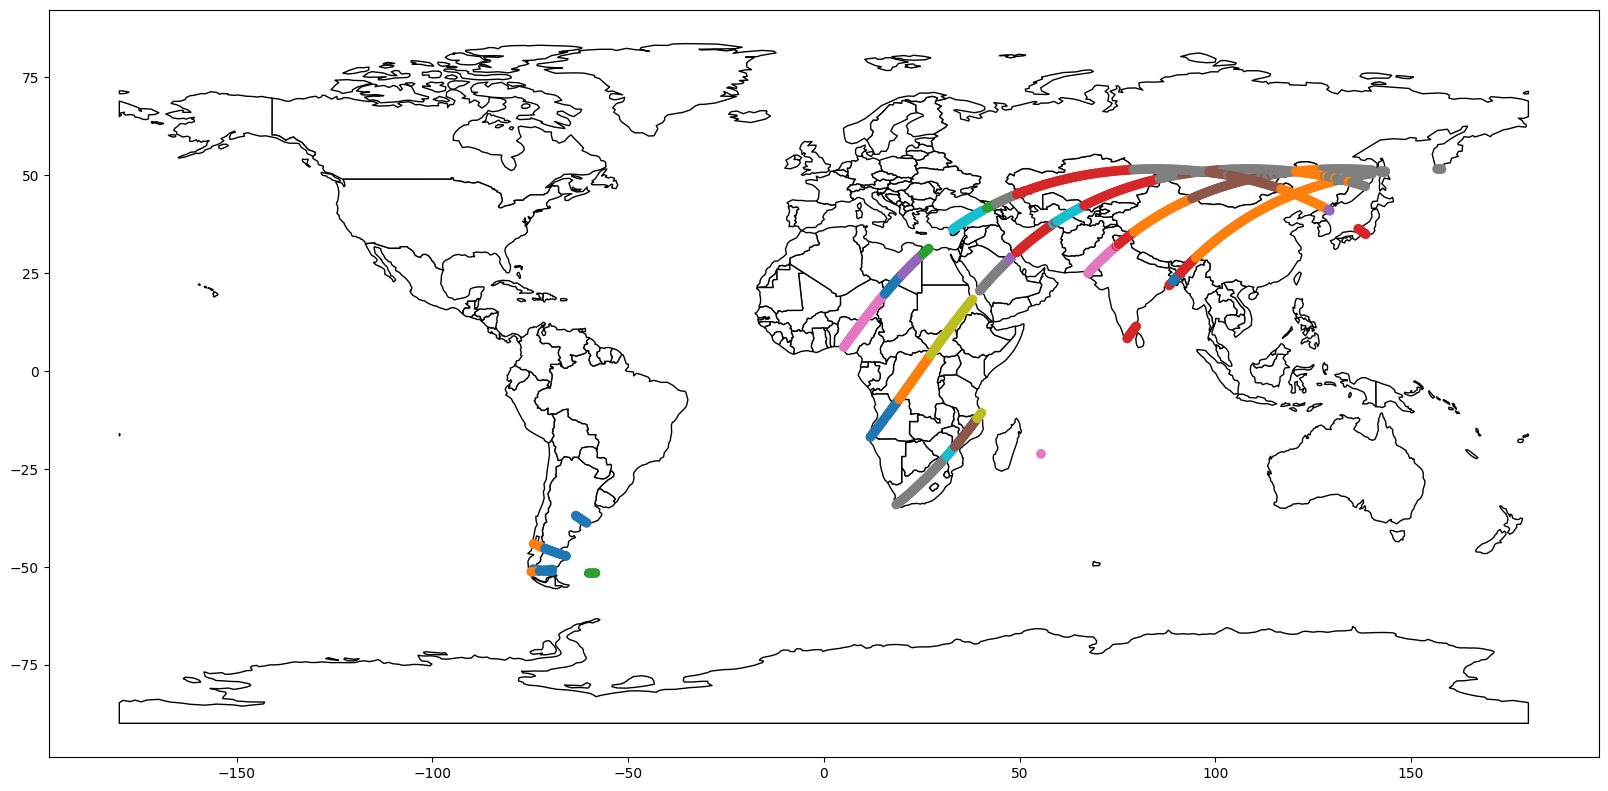

In [39]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_gdf[iss_gdf.land_flag==True].plot("country", ax=base);

# Step 4: Manipulation with MovingPandas

#### Create the MovingPandas trajectories

Create a GeoDataFram by specifying the Coordinate Reference System (CRS)

In [40]:
gdf_path = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'})

Create the MovingPandas trajectories

In [41]:
iss_trajc = mpd.TrajectoryCollection(gdf_path,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")

#### Quick plots

Simple plot with all the trajectories

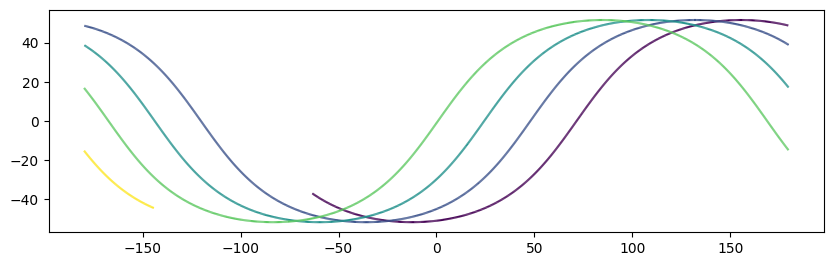

In [42]:
iss_trajc.plot(column='traj_id', figsize=(10,20));

Determine the number of trajectories

In [43]:
num_trajs = len(iss_trajc.trajectories)
print(f"Number of trajectories: {num_trajs}")

Number of trajectories: 5


Plot the individual trajectories

IndexError: list index out of range

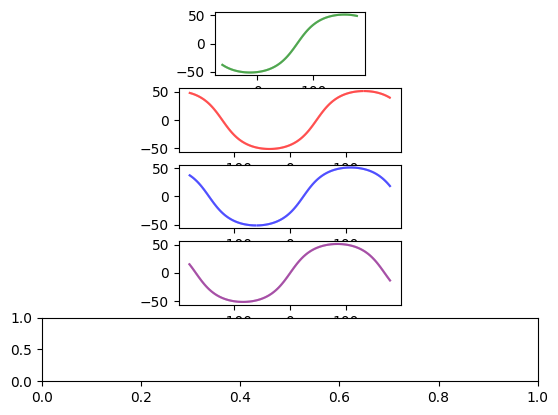

In [44]:
colors = ["green", "red", "blue", "purple"]
fig, ax = plt.subplots(num_trajs, 1)
for i in range(num_trajs):
    iss_trajc.trajectories[i].plot(ax=ax[i], color=colors[i])

#### Include Weather Data

<Axes: >

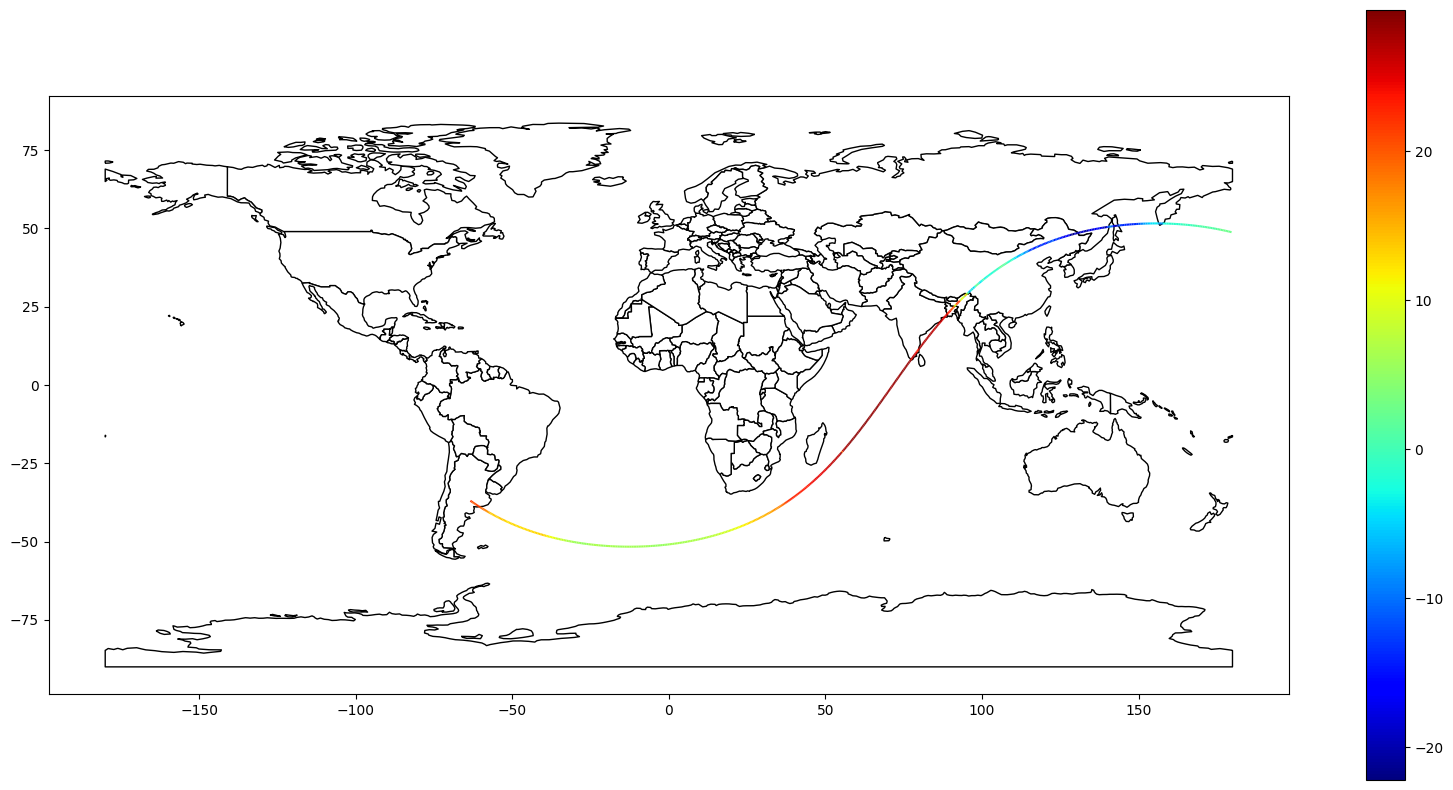

In [45]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[0].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

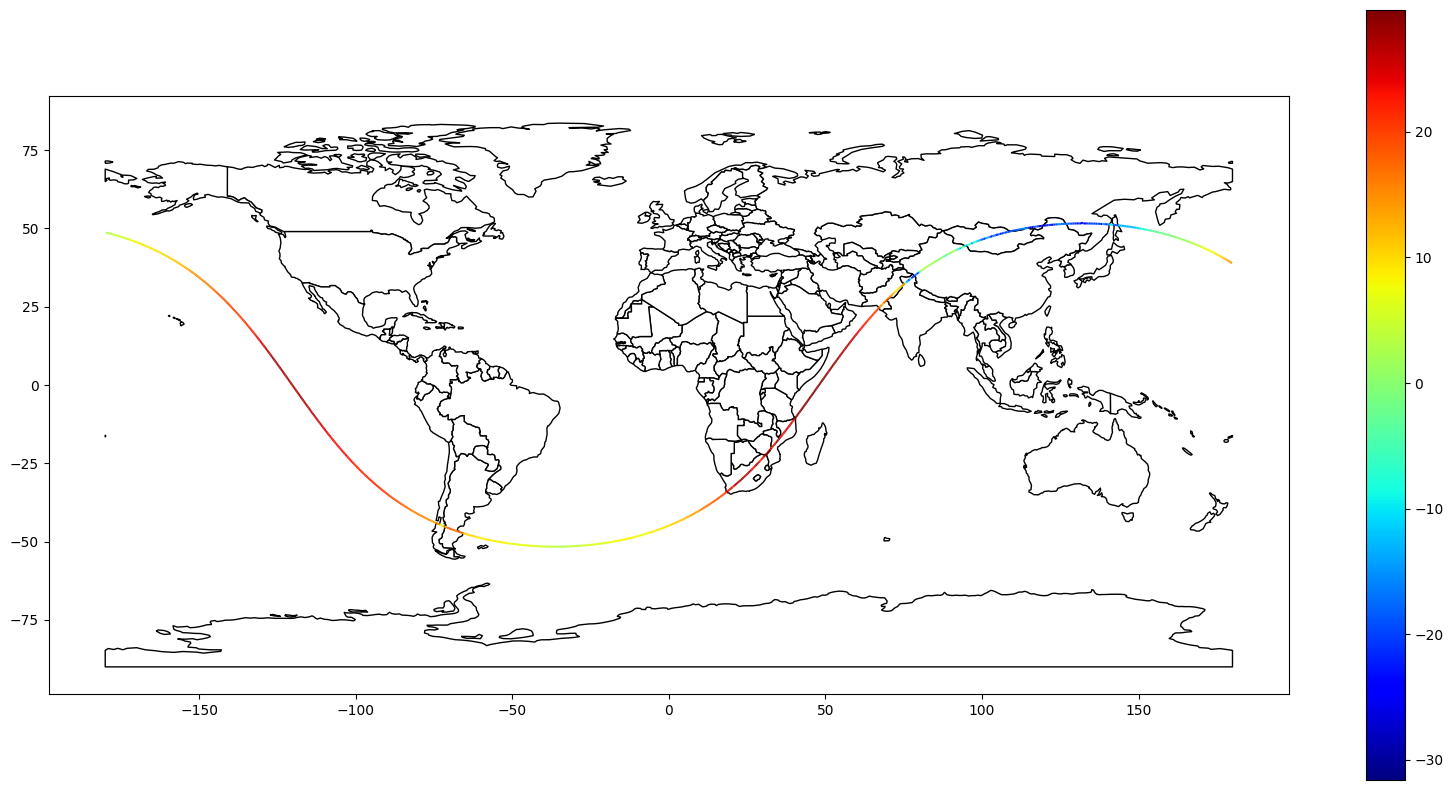

In [46]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[1].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

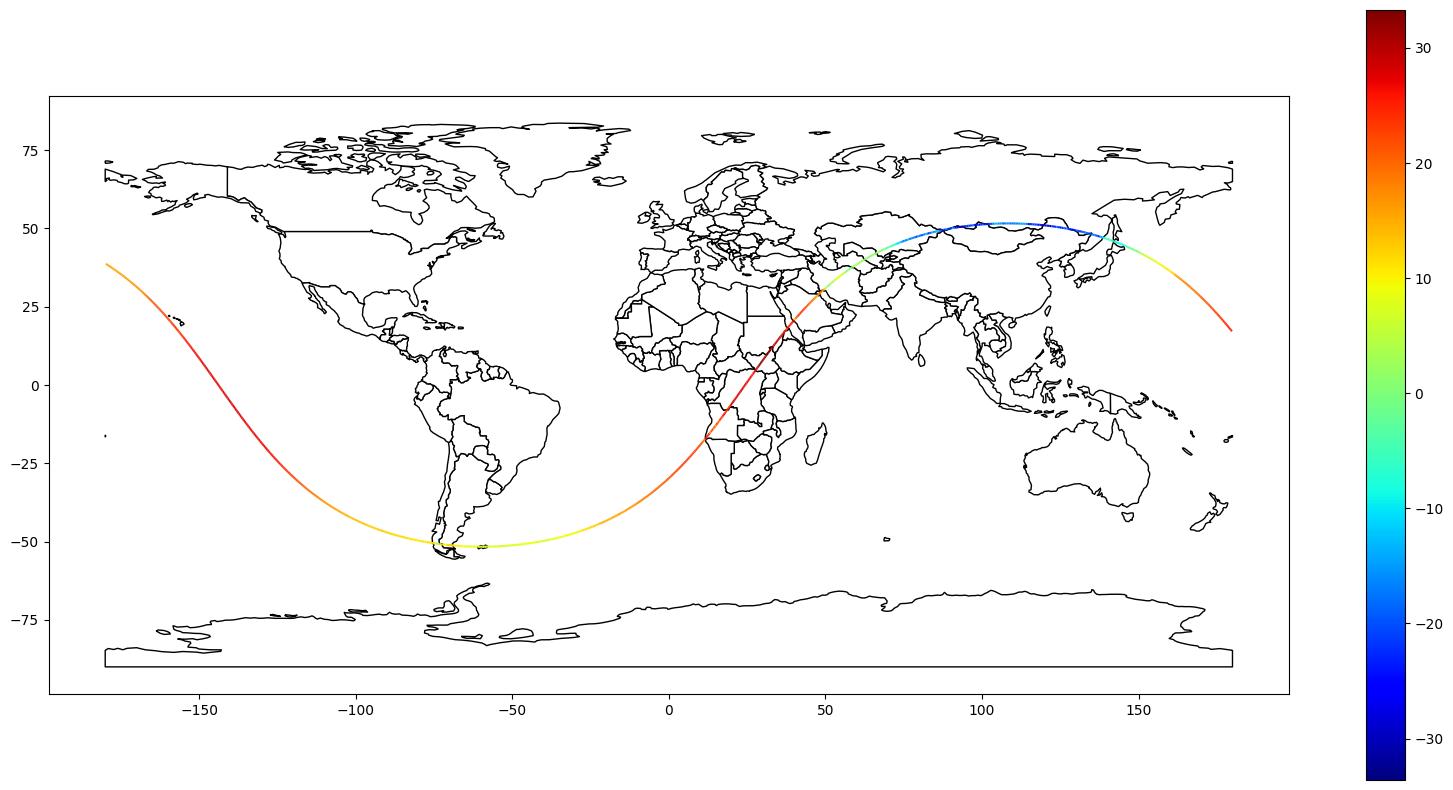

In [47]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[2].plot(ax=base, legend="true", column="temperature", cmap='jet')

#### Create interactive plots with weather data

In [48]:
iss_trajc.trajectories[1].hvplot(c="windspeed", tiles="OSM")

ImportError: Geographic projection support requires: geoviews.

In [49]:
gdf_path2 = gpd.GeoDataFrame(df[df.land_flag==True], crs={'init': 'epsg:4326'})
iss_trajc2 = mpd.TrajectoryCollection(gdf_path2,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")

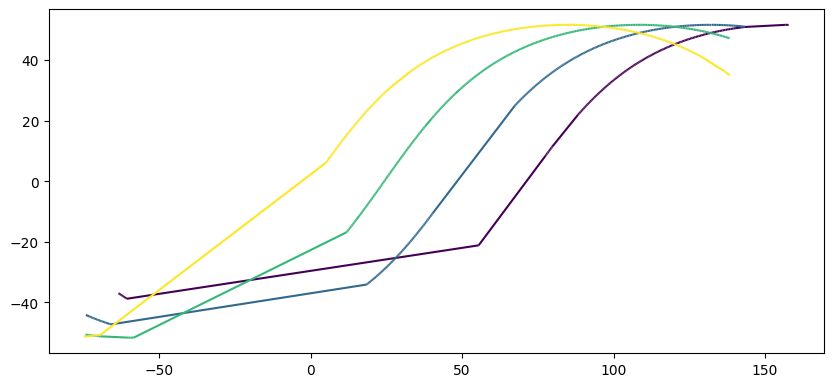

In [50]:
iss_trajc2.plot(column='traj_id', figsize=(10,20));